In [1]:
import os
import sys
import time
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from torch.utils.data import DataLoader
import torchvision

In [2]:
from utils import plot_spk_rec, plot_mem_rec, generate_random_silence_files

from scnn import SNN
from scnn.conv2d import SpikingConv2DLayer
from scnn.conv1d import SpikingConv1DLayer
from scnn.conv3d import SpikingConv3DLayer
from scnn.dense import SpikingDenseLayer
from scnn.readout import ReadoutLayer
from scnn.heaviside import SurrogateHeaviside

from scnn.optim import RAdam

In [3]:
from data.data_augmentor import data_augment, batchify

from tools.time_expector import TimeExpector
from tools.notify import notify
from sklearn.model_selection import train_test_split
te = TimeExpector()

In [4]:
batch_size = 16
nb_epochs = 2

In [5]:
# Check whether a GPU is available
if torch.cuda.is_available():
    print('using cuda...')
    device = torch.device("cuda")     
else:
    print('using cpu...')
    device = torch.device("cpu")
    
dtype = torch.float

using cpu...


In [6]:
CACHE_FOLDER_PATH = "/Users/aref/dvs-dataset/Cached"
DATASET_FOLDER_PATH = "/Users/aref/dvs-dataset/DvsGesture"

def load_data(trail):
    if trail.startswith('acc'):
        max_augmentation = 1
        augmentation = False
    else:
        max_augmentation = 3 if trail == 'train' else 1
        augmentation = True
    
    trail = trail.replace('acc_', '')
    return batchify(
        trail,
        DATASET_FOLDER_PATH,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=batch_size,
        augmentation=augmentation,
        max_augmentation=max_augmentation,
        frame=20
    )

In [7]:
spike_fn = SurrogateHeaviside.apply
layers = []

w_init_std = 0.15
w_init_mean = 0.1

in_channels = 1
out_channels = 16
kernel_size = (1,3,3)
dilation = (1,1,1)
input_shape = (64, 64)

# kernel_size = (3,3)
# dilation = (1,1)
# input_shape = 64*64

output_shape = input_shape # padding mode is "same"
layers.append(SpikingConv3DLayer(input_shape, output_shape,
                 in_channels, out_channels, kernel_size, dilation,
                 spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=True,
                               lateral_connections=True, flatten_output=True
                            ))


# in_channels = out_channels
# out_channels = 32
# kernel_size = (1,3,3)
# # dilation = (1,1,1)
# # input_shape = output_shape
# # output_shape = input_shape # padding mode is "same"
# layers.append(SpikingConv3DLayer(input_shape, output_shape,
#                  in_channels, out_channels, kernel_size, dilation,
#                  spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
#                               lateral_connections=True,
#                                 flatten_output=True))

# in_channels = out_channels
# out_channels = 64
# kernel_size = (4,3)
# dilation = (16,9)
# input_shape = output_shape
# output_shape = input_shape # padding mode is "same"
# layers.append(SpikingConv2DLayer(input_shape, output_shape,
#                  in_channels, out_channels, kernel_size, dilation,
#                  spike_fn, w_init_mean=w_init_mean, w_init_std=w_init_std, recurrent=False,
#                                lateral_connections=True, flatten_output=True))

# previous layer output has been flattened
input_shape = np.prod([output_shape[0], output_shape[1], out_channels])
# input_shape = output_shape*out_channels
print('-------------> input shape=', input_shape)
output_shape = 12
time_reduction="mean" # mean or max
layers.append(ReadoutLayer(input_shape, output_shape,
                 w_init_mean=w_init_mean, w_init_std=w_init_std, time_reduction=time_reduction))

snn = SNN(layers).to(device, dtype)

for X_batch, _ in load_data('train'):
#     _X_batch, _ = next(iter(train_dataloader))
#     print('_x: ', _X_batch.shape)
    
    shp = X_batch.shape
    X_batch = np.reshape(X_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
    X_batch = torch.from_numpy(X_batch).to(device, dtype)
    print(' x: ', X_batch.shape)
    
    snn(X_batch)

    for i,l in enumerate(snn.layers):
        if isinstance(l, SpikingDenseLayer) or \
           isinstance(l, SpikingConv2DLayer) or \
           isinstance(l, SpikingConv3DLayer):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
    break
print('done')

-------------> input shape= 65536
 x:  torch.Size([16, 1, 20, 64, 64])
Layer 0: average number of spikes=0.0297
done


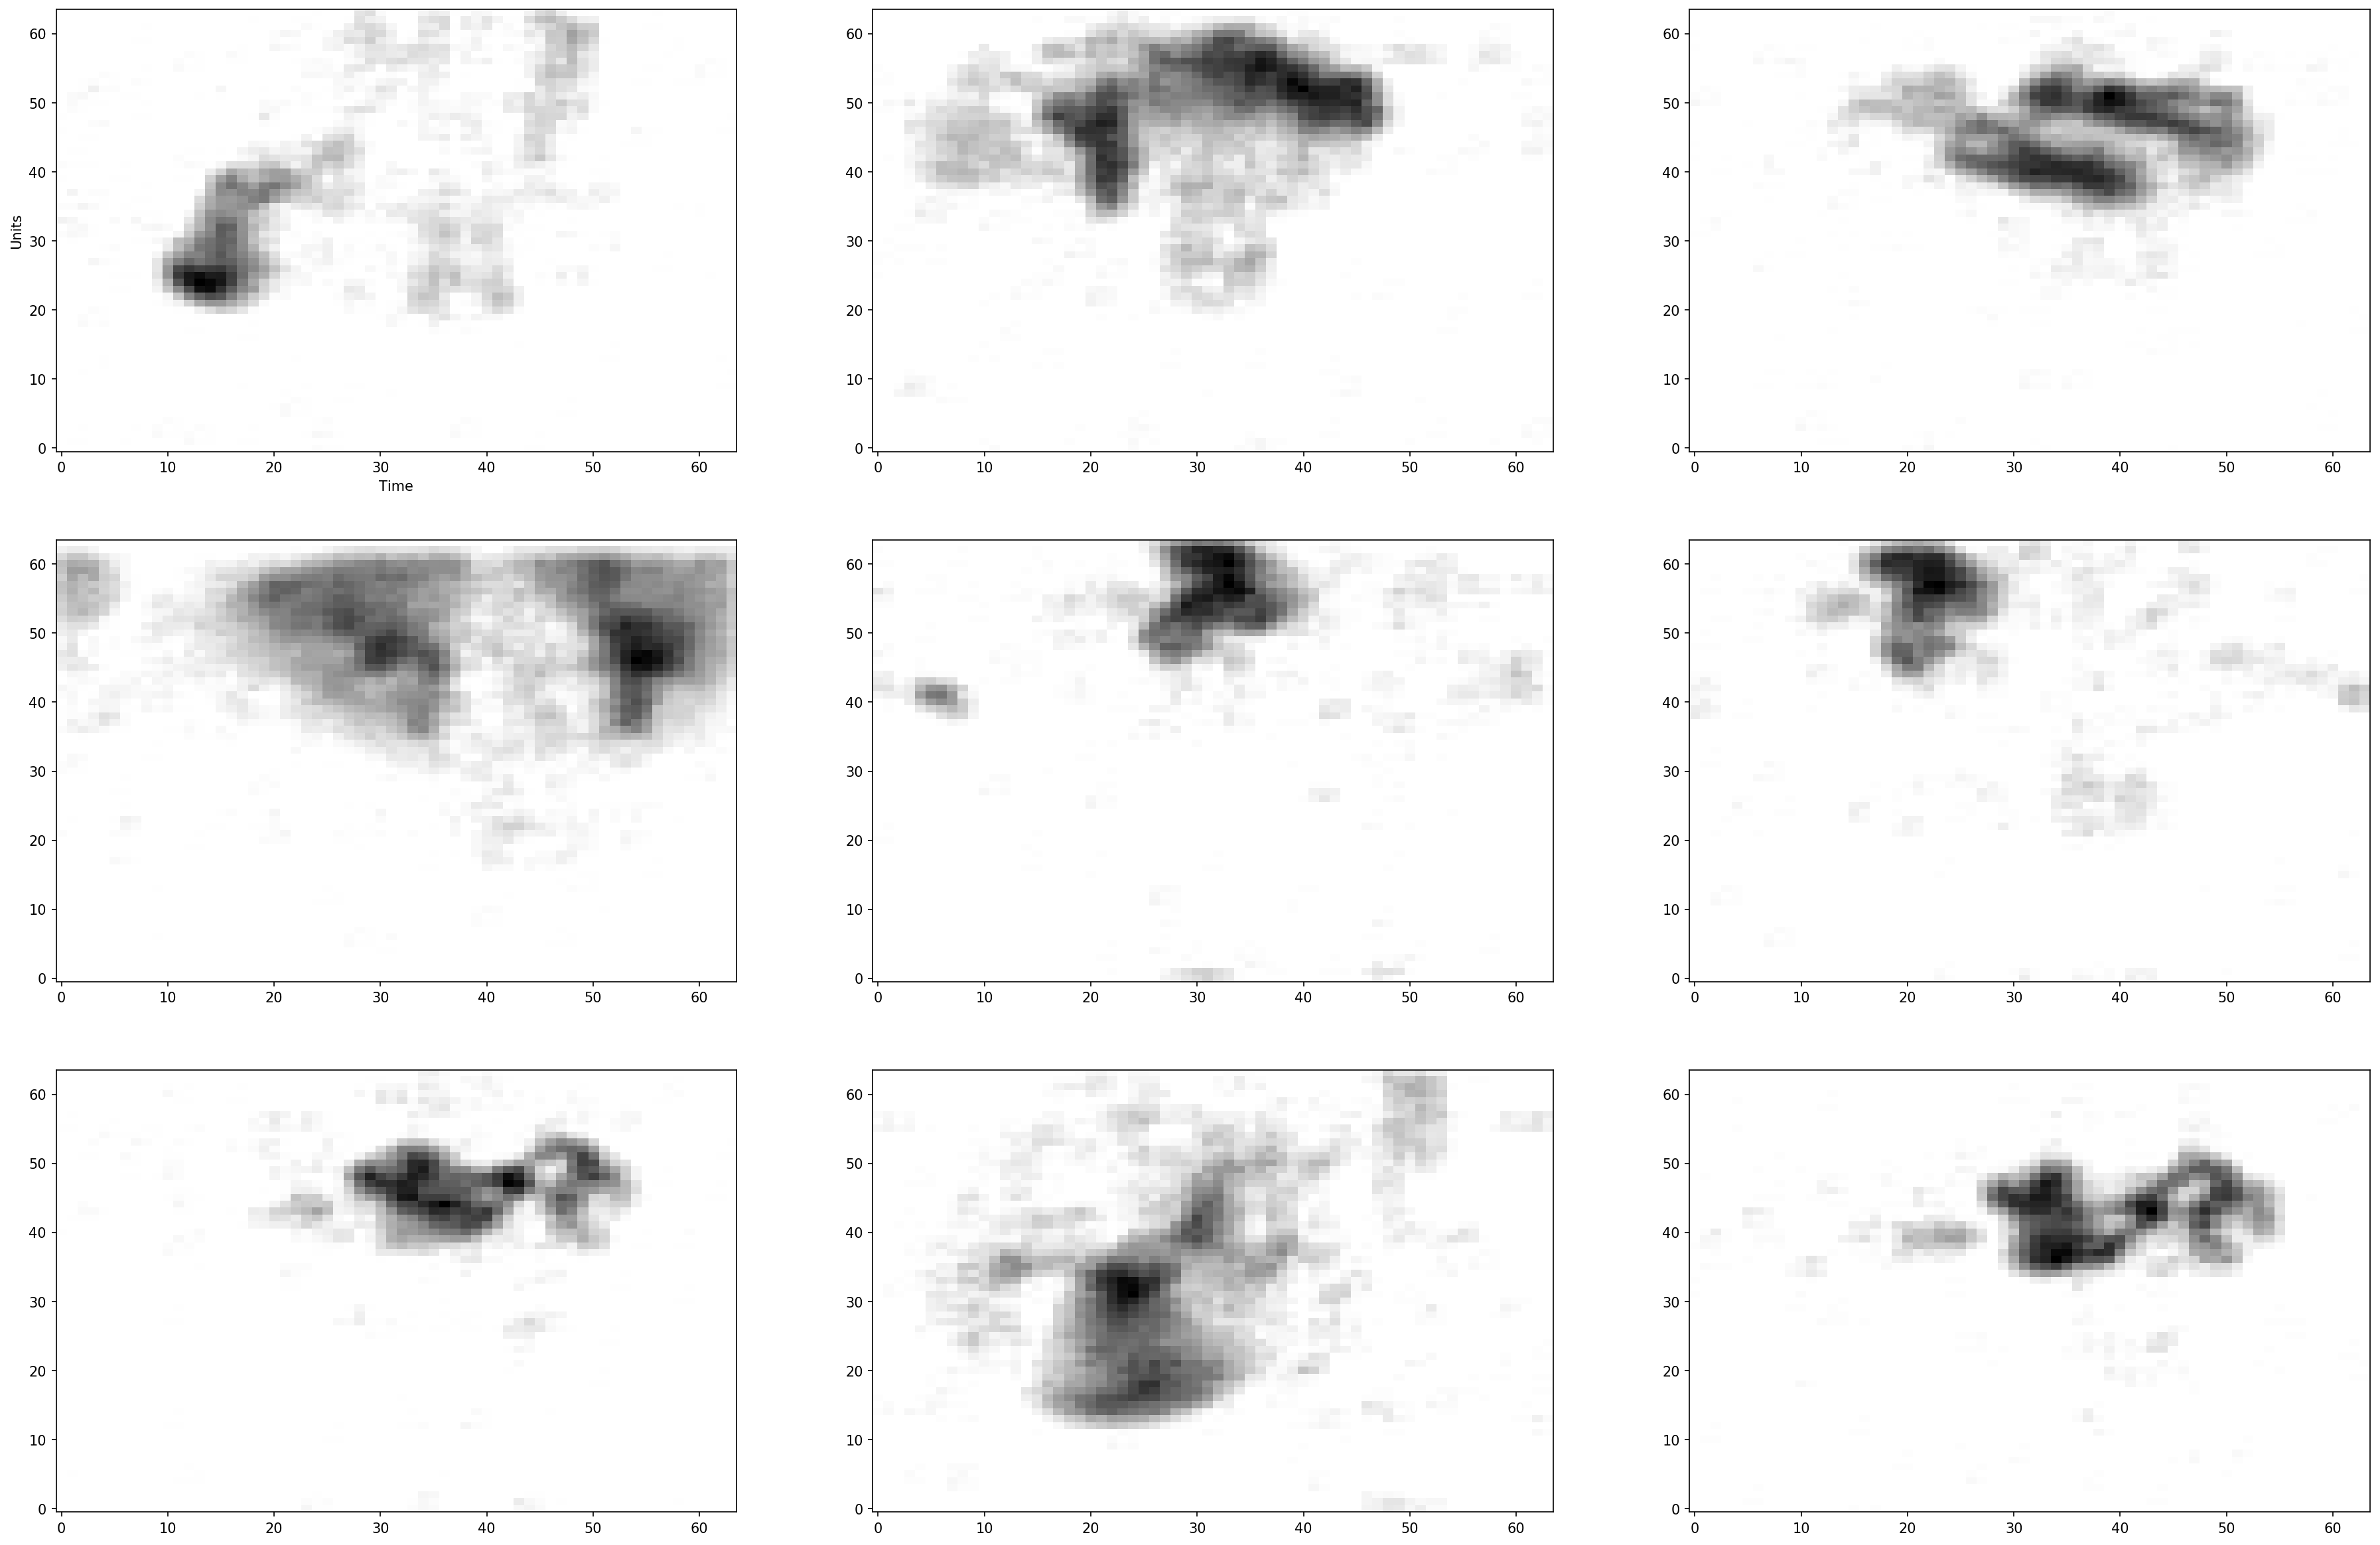

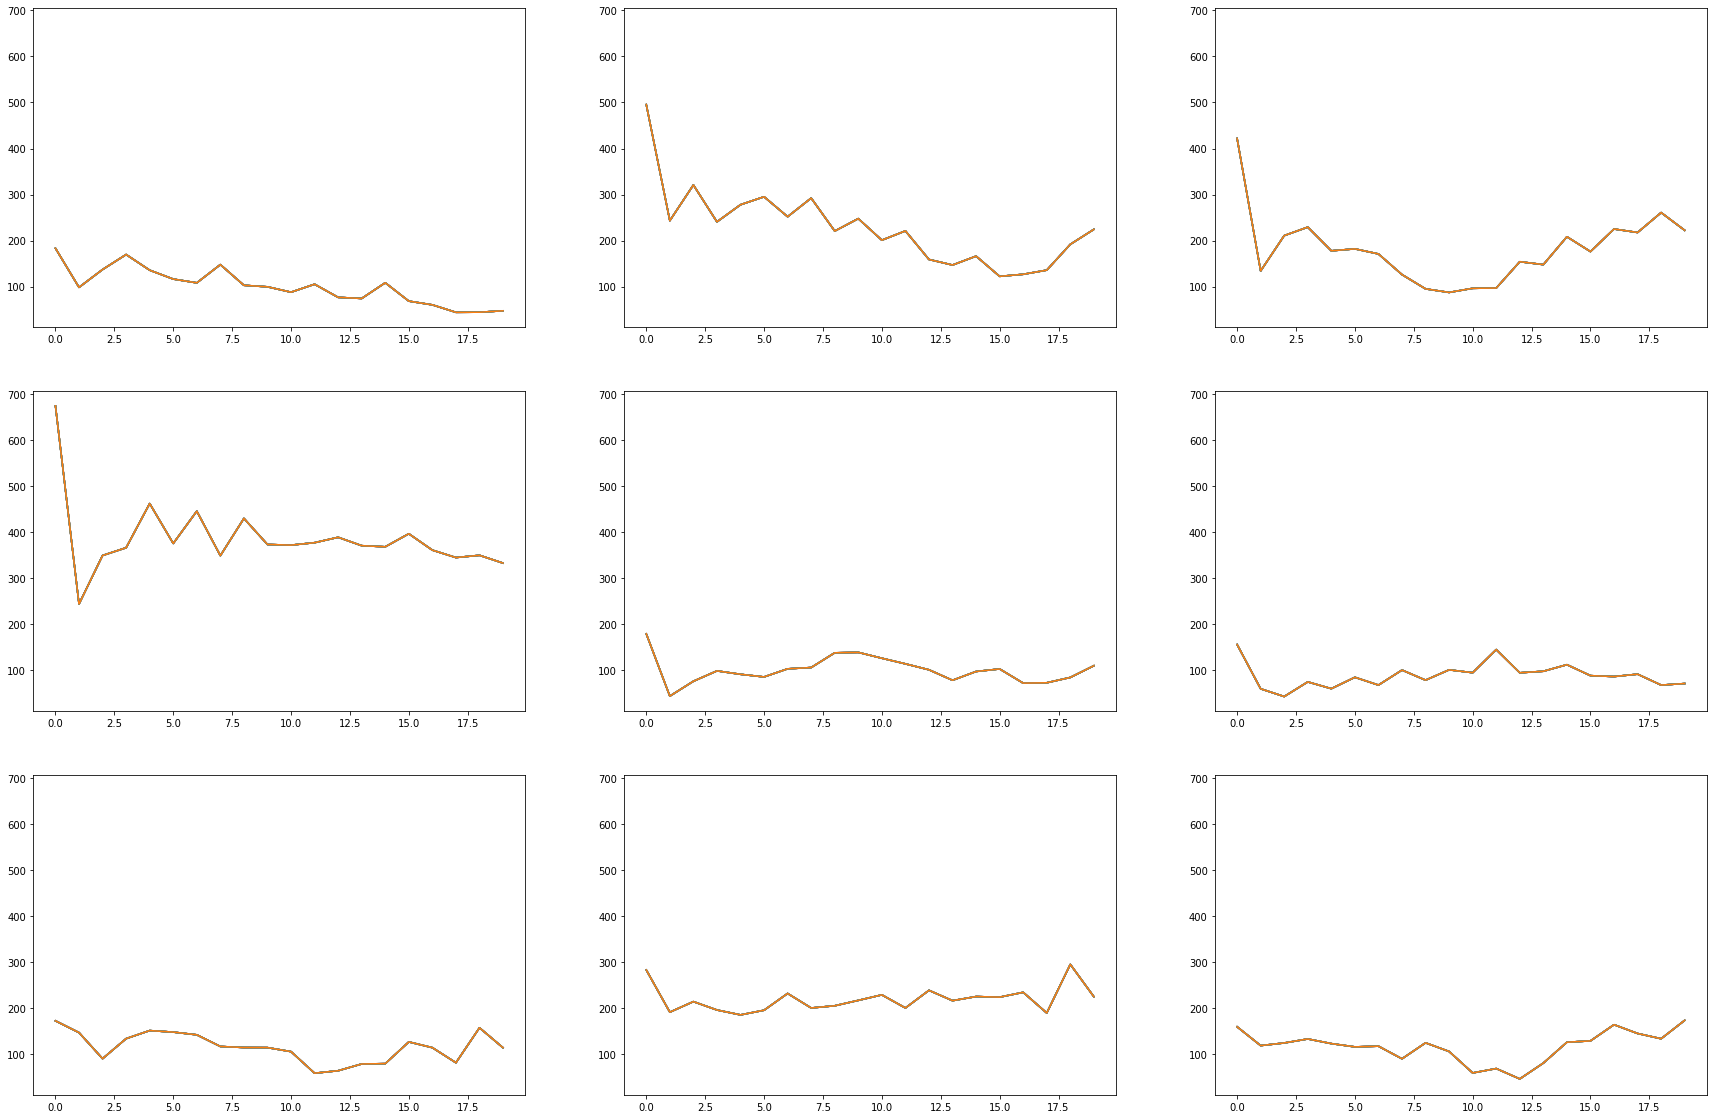

In [8]:
nb_plt = min(batch_size, 9)

batch_idx = np.random.choice(batch_size, nb_plt, replace=False)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
#     print('layer', i)
    if isinstance(l, SpikingDenseLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    elif isinstance(l, SpikingConv3DLayer):
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1).sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)

In [9]:
def print_progress(msg, value, width=100, a='=', b='>', c='.'):
    print('\r%s [%s%s%s] %d%%' % (msg, a*int(value*width), b, c*int((1.-value)*width), value*100), end='')

In [10]:
def train(model, params, optimizer, reg_loss_coef, nb_epochs, scheduler=None, warmup_epochs=0):
    dataset_size = 0.
    for x_batch, y_batch in load_data('train'):
        dataset_size += 1.
        print('\rpre-processing dataset: %d' % dataset_size, end='')
    print('')
    
    log_softmax_fn = torch.nn.LogSoftmax(dim=1)
    loss_fn = torch.nn.NLLLoss()
    
    if warmup_epochs > 0:
        for g in optimizer.param_groups:
            g['lr'] /= 1000*warmup_epochs
        warmup_itr = 1
    
    hist = {'loss':[], 'valid_accuracy':[]}
    for e in range(nb_epochs):
        te.tick(nb_epochs-e)
        print('\n')
        local_loss = []
        reg_loss = [[] for _ in range(len(model.layers)-1)]
        
        #with tqdm_notebook(total=len(train_dataloader)) as pb:
        e_2 = 0
        for x_batch, y_batch in load_data('train'):
            e_2 += 1
            print_progress('Epoch: %d' % e, e_2/dataset_size)
            #print('\r%d -- %d' % (e, e_2), end='')
            shp = x_batch.shape
            x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
        
        
            x_batch = torch.from_numpy(x_batch).to(device, dtype)
            y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)

#             print('a')
            output, loss_seq = model(x_batch)
            log_p_y = log_softmax_fn(output)
            loss_val = loss_fn(log_p_y, y_batch)
            local_loss.append(loss_val.item())

#             print('b')
#             for i,loss in enumerate(loss_seq[:-1]):
#                 print('  -', i)
#                 reg_loss_val = reg_loss_coef*loss*(i+1)/len(loss_seq[:-1])
#                 loss_val += reg_loss_val
#                 reg_loss[i].append(reg_loss_val.item())


            optimizer.zero_grad()
            loss_val.backward()
            torch.nn.utils.clip_grad_value_(model.parameters(), 5)
            optimizer.step()
            model.clamp()
            
            if e < warmup_epochs:
                for g in optimizer.param_groups:
                    g['lr'] *= (warmup_itr+1)/(warmup_itr)
                warmup_itr += 1
                
                #pb.update(1)
                
        if scheduler is not None and e >= warmup_epochs:
            scheduler.step()
        
        mean_loss = np.mean(local_loss)
        hist['loss'].append(mean_loss)
        print("  |  loss=%.5f"%(mean_loss))
        
        for i,loss in enumerate(reg_loss):
            mean_reg_loss = np.mean(loss)
            print("Layer %i: reg loss=%.5f"%(i,mean_reg_loss))
            
        for i,l in enumerate(snn.layers[:-1]):
            print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        
        valid_accuracy = compute_classification_accuracy(model, 'test')
        hist['valid_accuracy'].append(valid_accuracy)
        print("Validation accuracy=%.3f"%(valid_accuracy))
        te.tock()
        
    return hist
        
def compute_classification_accuracy(model, trail):
    accs = []
    
    with torch.no_grad():
        #with tqdm_notebook(total=len(dataloader)) as pb:
        for x_batch, y_batch in load_data(trail):
            shp = x_batch.shape
            x_batch = np.reshape(x_batch, [shp[0], 1, shp[1], shp[2], shp[3]])
            x_batch = torch.from_numpy(x_batch).to(device, dtype)
            y_batch = torch.from_numpy(y_batch.astype(np.long)).to(device)
            output, _ = model(x_batch)
            _,am=torch.max(output,1) # argmax over output units
            tmp = np.mean((y_batch==am).detach().cpu().numpy()) # compare to labels
            accs.append(tmp)
                #pb.update(1)
    return np.mean(accs)

In [ ]:
lr = 1e-3
weight_decay = 1e-5
reg_loss_coef = 0.1

params = [{'params':l.w, 'lr':lr, "weight_decay":weight_decay } for i,l in enumerate(snn.layers)]
params += [{
    'params':l.v, 'lr':lr, "weight_decay":weight_decay} for i,l in enumerate(snn.layers[:-1]) if l.recurrent]
params += [{'params':l.b, 'lr':lr} for i,l in enumerate(snn.layers)]
if snn.layers[-1].time_reduction == "mean":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers[:-1])]
elif snn.layers[-1].time_reduction == "max":
    params += [{'params':l.beta, 'lr':lr} for i,l in enumerate(snn.layers)]
else:
    raise ValueError("Readout time recution should be 'max' or 'mean'")
    
optimizer = RAdam(params)
 
gamma = 0.85
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma, last_epoch=-1)

hist = train(snn, params, optimizer, reg_loss_coef, nb_epochs=nb_epochs,
                  scheduler=scheduler, warmup_epochs=1)

test_accuracy = compute_classification_accuracy(snn, 'test')
print("Test accuracy=%.3f"%(test_accuracy))
test_accuracy = compute_classification_accuracy(snn, 'train')
print("Test accuracy=%.3f"%(test_accuracy))

pre-processing dataset: 6084


Epoch: 0 [===============================>....................................................................] 31%%

In [ ]:
snn(X_batch)

# Plotting spike trains or membrane potential
for i,l in enumerate(snn.layers):
    
    if isinstance(l, SpikingDenseLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec, idx=batch_idx)
    elif isinstance(l, SpikingConv2DLayer):
        print("Layer {}: average number of spikes={:.4f}".format(i,l.spk_rec_hist.mean()))
        spk_rec = l.spk_rec_hist
        plot_spk_rec(spk_rec.sum(1), idx=batch_idx)
    else:
        mem_rec = l.mem_rec_hist
        plot_mem_rec(mem_rec, batch_idx)